# データ読み込み

In [1]:
import pandas as pd
import numpy as np
import os
import time
from contextlib import contextmanager

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# まずfeatherに変換しておく
def load(path):
    if not os.path.exists(path+'.f'):
        pd.read_csv(path).to_feather(path+'.f')
    return pd.read_feather(path+'.f')

with timer('load data'):
    aisles      = load('../input/aisles.csv')
    departments = load('../input/departments.csv')
    prior       = load('../input/order_products__prior.csv')
    train       = load('../input/order_products__train.csv')
    orders      = load('../input/orders.csv')
    products    = load('../input/products.csv')

load data - done in 4s


# 前処理

In [2]:
with timer('combine all'):
    # 全データをまとめる
    all = pd.merge(orders, pd.concat([train, prior]), on='order_id', how='left')
    all.head()

combine all - done in 27s


In [3]:
with timer('make unique'):
    # user x itemで最後のデータだけを残す
    last_order_by_user_x_item = all.drop_duplicates(subset=['user_id','product_id'], keep='last')
    last_order_by_user_x_item = last_order_by_user_x_item[
        (last_order_by_user_x_item['eval_set'] != 'train') |
        (last_order_by_user_x_item['reordered'] == 1)
    ]

make unique - done in 40s


In [4]:
# user x productを1行として、Train/Testの区分と目的変数の値を入れておく
# 特徴量エンジニアリングはこのテーブルを基準にすることとする
with timer('make user_id x product_id x target x is_train'):
    # train/testでユーザーが振り分けられているので、trainに属するuserかどうかを列に追加
    train_users = orders[['eval_set','user_id']][orders['eval_set'] =='train']
    X = last_order_by_user_x_item[['user_id','product_id','eval_set']].dropna()
    X['is_train'] = X['user_id'].isin(train_users['user_id'])
    X['target'] = (X['eval_set'] == 'train').astype(np.int32)
    X['product_id'] = X['product_id'].astype(np.int32)
    X.drop('eval_set', axis=1, inplace=True)
X.head()

make user_id x product_id x target x is_train - done in 9s


,user_id,product_id,is_train,target
1,1,14084,True,0
15,1,30450,True,0
25,1,10326,True,0
26,1,17122,True,0
27,1,41787,True,0


In [6]:
if not os.path.exists('all.f'):
    all.to_feather('all.f')

In [8]:
if not os.path.exists('X.f'):
    X.reset_index().to_feather('X.f')

# 特徴量エンジニアリング

In [10]:
# 過去の注文のみ
all_prior = all[all['eval_set'] == 'prior']

### 過去そのアイテムを何回注文しているか

In [11]:
n_orders = all_prior\
    .groupby(['user_id','product_id'])['order_number'] \
    .count() \
    .reset_index() \
    .rename(columns={'order_number':'n_orders'})
X = pd.merge(X, n_orders, on=['user_id','product_id'], how='left')

### どれくらいよくリピートする人か

In [12]:
reorder_rate = all_prior\
    .groupby(['user_id'])['reordered'] \
    .mean() \
    .reset_index() \
    .rename(columns={'reordered':'reorder_rate'})
X = pd.merge(X, reorder_rate, on=['user_id'], how='left')

### product情報

In [13]:
X = pd.merge(X, products.drop('product_name',axis=1), on='product_id', how='left')
X.head()

,user_id,product_id,is_train,target,n_orders,reorder_rate,aisle_id,department_id
0,1,14084,True,0,1,0.694915,91,16
1,1,30450,True,0,1,0.694915,88,13
2,1,10326,True,0,1,0.694915,24,4
3,1,17122,True,0,1,0.694915,24,4
4,1,41787,True,0,1,0.694915,24,4


### そのユーザの最後の注文番号(＝総注文回数)

In [14]:
max_user_order_number = all[all['eval_set'] != 'prior']\
    .groupby(['user_id'])\
    .max()['order_number']\
    .reset_index()\
    .rename(columns={'order_number': 'max_user_order_number'})
X = pd.merge(X, max_user_order_number, on=['user_id'], how='left')

### priorにおけるそのアイテムの最後の注文番号

In [15]:
last_order_number = all[all['eval_set'] == 'prior']\
    .groupby(['user_id', 'product_id'])['order_number']\
    .max()\
    .reset_index()\
    .rename(columns={'order_number': 'last_order_number'})
last_order_number['product_id'] = last_order_number['product_id'].astype('int32')
X = pd.merge(X, last_order_number, on=['user_id', 'product_id'], how='left')

### 最後にアイテムを買って経過した注文の回数
最後に買ってから回数が開けば開くほど買いずらそう(調味料とかはそうでもないかも)

In [16]:
X['diff_order_number'] = X['max_user_order_number'] - X['last_order_number']

### ユーザごとのアイテムのリピート率

In [17]:
X['product_order_rate'] = X['n_orders'] / X['max_user_order_number']

In [18]:
X.head()

,user_id,product_id,is_train,target,n_orders,reorder_rate,aisle_id,department_id,max_user_order_number,last_order_number,diff_order_number,product_order_rate
0,1,14084,True,0,1,0.694915,91,16,11,1,10,0.090909
1,1,30450,True,0,1,0.694915,88,13,11,3,8,0.090909
2,1,10326,True,0,1,0.694915,24,4,11,5,6,0.090909
3,1,17122,True,0,1,0.694915,24,4,11,5,6,0.090909
4,1,41787,True,0,1,0.694915,24,4,11,5,6,0.090909


### アイテム自体の平均リピート率

In [19]:
product_repeat_mean_rate = X[['product_id', 'product_order_rate']]\
    .groupby('product_id')['product_order_rate']\
    .mean()\
    .reset_index()\
    .rename(columns={'product_order_rate': 'product_order_mean_rate'})
X = pd.merge(X, product_repeat_mean_rate, on=['product_id'], how='left')

In [38]:
orders.head(n=40).sort_values('user_id').groupby('user_id')['days_since_prior_order'].sum()

user_id
1    190.0
2    228.0
3    144.0
4      0.0
Name: days_since_prior_order, dtype: float64

# モデル作成

In [22]:
import lightgbm as lgb

with timer('split data'):
    X.set_index('user_id', inplace=True)
    X['product_id'] = X['product_id'].astype(np.int32)
  
    X_train = X[X['is_train']].drop('is_train', axis=1)
    X_test  = X[~X['is_train']].drop('is_train', axis=1)

    dtrain = lgb.Dataset(X_train.drop(['target'], axis=1), X_train['target'])
    
    print('train: {}, test: {}'.format(X_train.shape, X_test.shape))
    
X_train.head()

train: (8474661, 11), test: (4833292, 11)
split data - done in 8s


,product_id,target,n_orders,reorder_rate,aisle_id,department_id,max_user_order_number,last_order_number,diff_order_number,product_order_rate,product_order_mean_rate
user_id,,,,,,,,,,,
1,14084,0,1,0.694915,91,16,11,1,10,0.090909,0.243518
1,30450,0,1,0.694915,88,13,11,3,8,0.090909,0.125801
1,10326,0,1,0.694915,24,4,11,5,6,0.090909,0.174475
1,17122,0,1,0.694915,24,4,11,5,6,0.090909,0.176111
1,41787,0,1,0.694915,24,4,11,5,6,0.090909,0.150892


In [23]:
# Cross-Validation
boosters = []
from sklearn.model_selection import KFold
for train_idx, _test_idx in KFold(n_splits=3).split(X_train):
    print('split...')
    xs_train = X_train.iloc[train_idx].drop(['target'], axis=1)
    y_train = X_train.iloc[train_idx]['target']
    dtrain = lgb.Dataset(xs_train, y_train)
    print('train...')
    best_round = 300
    booster = lgb.train({
        'objective' : 'binary',
        'boosting_type': 'gbdt',
        'metric' : 'binary_logloss',
        'num_leaves' : 15,
        'seed' : 0,
        'learning_rate' : 0.1
    }, dtrain, num_boost_round=int(best_round * 1.1))
    boosters.append(booster)
    print()

split...
train...

split...
train...

split...
train...



In [24]:
# Cross-Validation
from sklearn.model_selection import KFold
y_preds = []
y_tests = []
for i, (_train_idx, test_idx) in enumerate(KFold(n_splits=3).split(X_train)):
    print('split...')
    xs_test = X_train.iloc[test_idx].drop(['target'], axis=1)
    y_test = X_train.iloc[test_idx]['target']

    print('predict...')
    y_pred = boosters[i].predict(xs_test).tolist()
    y_preds = y_preds + y_pred
    y_tests = y_tests + y_test.tolist()
    print()

split...
predict...

split...
predict...

split...
predict...



max score: 0.4314389869884209
best threshold: 0.21034482758620693


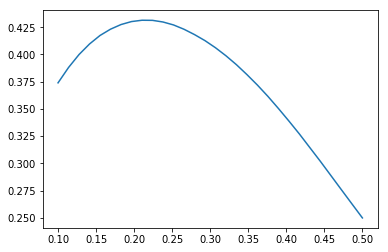

In [25]:
# 適切な閾値を探す
from sklearn.metrics import f1_score
thresholds = np.linspace(0.1, 0.5, 30)
scores = np.array([f1_score(y_tests, y_preds > thr) for thr in thresholds])
plt.plot(thresholds, scores)
best_threshold = thresholds[scores.argmax()]
print('max score: {}'.format(scores.max()))
print('best threshold: {}'.format(best_threshold))

In [48]:
# 全部つかって学習
with timer('lgbm training'):
    best_round = 500 # TODO CVのearly-stoppingからイテレーション数を決める
    booster = lgb.train({
        'objective' : 'binary',
        'boosting_type': 'gbdt',
        'metric' : 'binary_logloss',
        'num_leaves' : 15,
        'seed' : 0,
        'learning_rate' : 0.01
    }, dtrain, num_boost_round=int(best_round * 1.1))

lgbm training - done in 171s


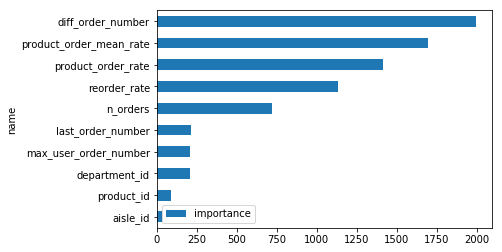

In [49]:
pd.DataFrame(
    data=[c for c in zip(X_train.columns.drop('target'), booster.feature_importance())],
    columns=['name', 'importance']
).sort_values('importance').plot(x='name', kind='barh')

In [50]:
predicted = X_test.reset_index()[['user_id','product_id']]

test_users = orders[['eval_set','user_id','order_id']][orders['eval_set'] =='test']
predicted = pd.merge(predicted, test_users, on='user_id', how='left')

predicted['y'] = booster.predict(X_test.drop('target',axis=1))

In [51]:
th = best_threshold

predicted['product_id'] = predicted['product_id'].astype(str)

# 閾値を超えた行だけを抜き出して、submit用に整形
sub = predicted[predicted['y'] > th].groupby(['order_id'])['product_id'] \
                                    .apply(lambda x: ' '.join(x)) \
                                    .reset_index() \
                                    .rename(columns={'product_id':'products'})

# 閾値をひとつも超えなかったオーダーが抜けてしまうので、Join->fillnaでNoneを埋める
sub = pd.merge(test_users[['order_id']], sub, on='order_id', how='left')
sub.fillna('None', inplace=True)

sub.sort_values(by='order_id', inplace=True)
sub.head()

,order_id,products
13407,17,21709 47766 13107 21463
12775,34,39180 21137 43504 47766 16083 2596 39475 13176...
68056,137,38689 29594 25890 24852 41787 23794 5134 2326
42239,182,47209 13629 5479 47672 9337 39275 33000
12915,257,45013 4605 24838 13870 21137 49235 24852 30233...


In [52]:
sub.to_csv('../output/submission.csv', index=False)